In [1]:
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

import sys
sys.path.append('/research/astro/highz/Students/Chris/sed_modelling')

import sph2sed

If the intrinsic SED grid has not yet been generated, generate a new one and pickle

In [2]:
# sph2sed.intrinsic.fsps.pickle_grid(Nage=60, NZ=15)

Initialise sed object

In [3]:
sp = sph2sed.model.sed()

load intrinsic SED from pickle

In [71]:
sp.load_grid(name='fsps_neb')

Loading fsps_neb model from: 

/research/astro/highz/Students/Chris/sed_modelling/grids/intrinsic/output/fsps_neb.p

Age array not sorted ascendingly. Sorting...



Now have intrinsic `grid`, with arrays for `metallicity`, `age` and `wavelength`

In [72]:
sp.grid.shape

(10, 40, 5994)

In [73]:
sp.metallicity

array([ 0.23622047,  0.64741907,  1.05861767,  1.46981627,  1.88101487,
        2.29221347,  2.70341207,  3.11461067,  3.52580927,  3.93700787])

In [74]:
sp.age

array([ 0.08062241,  0.3515983 ,  0.50642043,  0.61909752,  0.70536205,
        0.77236288,  0.82452142,  0.86504683,  0.8964334 ,  0.92066266,
        0.93931222,  0.95363193,  0.96460525,  0.97300093,  0.97941653,
        0.98431432,  0.9880506 ,  0.9908992 ,  0.99307006,  0.99472386,
        0.99598344,  0.99694258,  0.99767283,  0.99822876,  0.99865193,
        0.99897403,  0.99921919,  0.99940577,  0.99954778,  0.99965585,
        0.9997381 ,  0.99980069,  0.99984832,  0.99988457,  0.99991216,
        0.99993315,  0.99994913,  0.99996129,  0.99997054,  0.99997758])

In [75]:
sp.wavelength

array([  9.10000000e+01,   9.40000000e+01,   9.60000000e+01, ...,
         9.81700000e+07,   9.90800000e+07,   1.00000000e+08])

Load some hydro particle data

In [76]:
pickle = pcl.load(open("data/full_histories_eagle.p", "rb"), encoding='latin1')

## Eagle mass multiplier
for key, value in pickle['data'].items():
    value['history']['InitialStellarMass'] *= 1e10


In [77]:
N = 10
for key, value in {k: pickle['data'][k] for k in list(pickle['data'].keys())[:N]}.items():
    
    sp.insert_galaxy(key, value['history']['InitialStellarMass'],
                     value['history']['formationTime'],
                     value['history']['Metallicity'],
                     Metallicity=value['SF/Metallicity'],
                     StellarMass=value['mstar'],
                     SFR=value['sfr'])


In [78]:
idx = list(sp.galaxies.keys())[0]
print(idx)

395264


In [79]:
sp.intrinsic_spectra(idx)                    # intrinsic
sp.dust_screen(idx, metal_dependent=False)   # galaxy-independent dust screen
sp.dust_screen(idx, metal_dependent=True)    # metallicity-dependent dust screen

Adding metallicity dependence to optical depth values


(900.0, 9000.0)

/home/c/cl/cl478/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


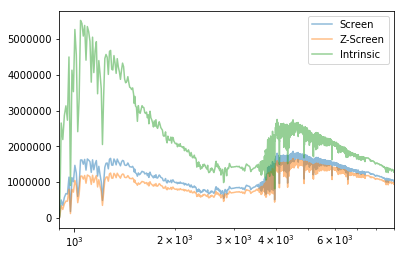

In [80]:
plt.semilogx(sp.wavelength, sp.galaxies[idx]['Screen Spectra'], label='Screen', alpha=0.5)
plt.semilogx(sp.wavelength, sp.galaxies[idx]['Z-Screen Spectra'], label='Z-Screen', alpha=0.5)
plt.semilogx(sp.wavelength, sp.galaxies[idx]['Intrinsic Spectra'], label='Intrinsic', alpha=0.5)
plt.legend()

plt.xlim(9e2, 9e3)

Apply to all galaxies

In [81]:
sp.all_galaxies(sp.intrinsic_spectra)
sp.all_galaxies(sp.dust_screen)
sp.all_galaxies(sp.dust_screen, metal_dependent=True);

Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values
Adding metallicity dependence to optical depth values


(912.0, 9000.0)

/home/c/cl/cl478/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


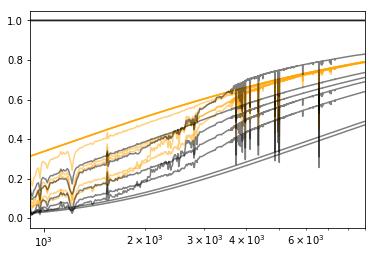

In [82]:
plt.semilogx(sp.wavelength, np.array([value['Screen Spectra'] for key, value in sp.galaxies.items()]).T /\
        np.array([value['Intrinsic Spectra'] for key, value in sp.galaxies.items()]).T, 
             color='orange', alpha=0.5);

plt.semilogx(sp.wavelength, np.array([value['Z-Screen Spectra'] for key, value in sp.galaxies.items()]).T /\
        np.array([value['Intrinsic Spectra'] for key, value in sp.galaxies.items()]).T, 
             color='black', alpha=0.5);

plt.xlim(9.12e2, 9e3)
# plt.ylim(0,30)

(900.0, 9000.0)

/home/c/cl/cl478/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


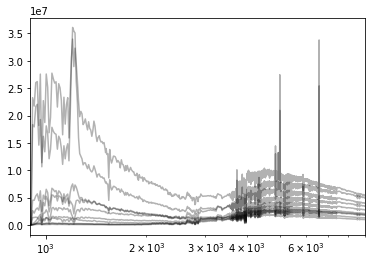

In [83]:
plt.semilogx(sp.wavelength, np.array([value['Intrinsic Spectra'] for key, value in sp.galaxies.items()]).T, 
         alpha=0.3, c='black');

plt.xlim(9e2, 9e3)

(900.0, 9000.0)

/home/c/cl/cl478/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


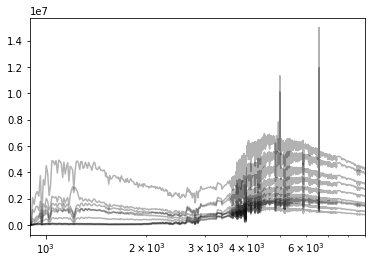

In [84]:
plt.semilogx(sp.wavelength, np.array([value['Screen Spectra'] for key, value in sp.galaxies.items()]).T, 
         alpha=0.3, c='black');

plt.xlim(9e2, 9e3)

(900.0, 9000.0)

/home/c/cl/cl478/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


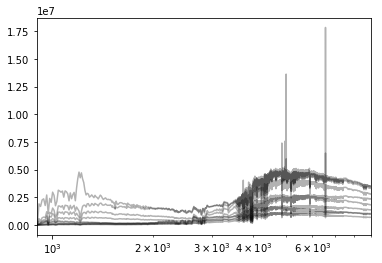

In [85]:
plt.semilogx(sp.wavelength, np.array([value['Z-Screen Spectra'] for key, value in sp.galaxies.items()]).T, 
         alpha=0.3, c='black');

plt.xlim(9e2, 9e3)